In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
# from google.colab import drive
# drive.mount('/content/drive')
import pandas as pd
from torchvision.io import decode_image
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, datasets

Define Constants

In [9]:
labels_map = {
    0: "Anthracnose",
    1: "Banana Fruit-Scarring Beetle",
    2: "Banana Skipper Damage",
    3: 'Banana Split Peel',
    4: "Black and Yellow Sigatoka",
    5: "Chewing insect damage on banana leaf",
    6: "Healthy Banana",
    7: "Healthy Banana leaf",
    8: "Panama Wilt Disease",
}
root_dir = '/home/jovyan/bananadata'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Define HyperParameters

In [3]:
num_classes = 9
# hyperparams
num_epochs = 1
batch_size = 64
learning_rate = 0.01
decay = 0.001
moment = 0.9

Import image dataset from drive

In [10]:

dataset_path = root_dir +'/bananadata/AUGMENTED/data'
build_path = root_dir +'/bananadata/build/augs'


Define Image transformations to fit model

In [11]:
normalize = transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    )
transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize
    ])


Get images from drive and apply Transfomation to image datasets

In [12]:
dataset_train = datasets.ImageFolder(root=dataset_path+'/train', transform=transform)
dataset_val = datasets.ImageFolder(root=dataset_path+'/validation', transform=transform)
dataset_test = datasets.ImageFolder(root=dataset_path+'/test', transform=transform)
build_train = datasets.ImageFolder(root=build_path, transform=transform)

load images to DataLoader

In [13]:

load_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
load_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
load_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
load_build = DataLoader(build_train, batch_size=batch_size, shuffle=True)

In [14]:
load_train.dataset

Dataset ImageFolder
    Number of datapoints: 7605
    Root location: /home/jovyan/bananadata/bananadata/AUGMENTED/data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [15]:
for images, labels in load_val:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 3, 224, 224])
torch.Size([64])


Define VGG16 architecture CNN model

In [17]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

Define model

In [18]:
model = VGG16(num_classes).to(device)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = decay, momentum = moment)


# Train the model
total_step = len(load_train)



In [ ]:
# only run this if there is already a saved model in the directory
model_path = root_dir + '/bananadata/results/cnn/models/CNNmodel1.pth' # Replace with proper name of saved model
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
optimizer.load_state_dict(torch.load(root_dir + '/bananadata/results/cnn/models/optimizer1.pth')) # replace this with proper name of saved model

### Training

In [ ]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, batch in enumerate(load_train):
        # Move tensors to the configured device
        images = batch[0].to(device)
        labels = batch[1].to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(load_train.dataset)
    train_losses.append(train_loss)

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    running_loss = 0.0
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in load_val:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item() * labels.size(0)
            del images, labels, outputs
        val_loss = running_loss / len(load_val.dataset)
        val_losses.append(val_loss)
        val_acc = 100 * correct / total
        val_accuracies.append(val_acc)
        print('Accuracy of the network on the {} validation images: {} %'.format(945, 100 * correct / total))


Epoch [1/1], Step [119/119], Loss: 0.6280


NameError: name 'labels' is not defined

## PLOTS

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

loss plots

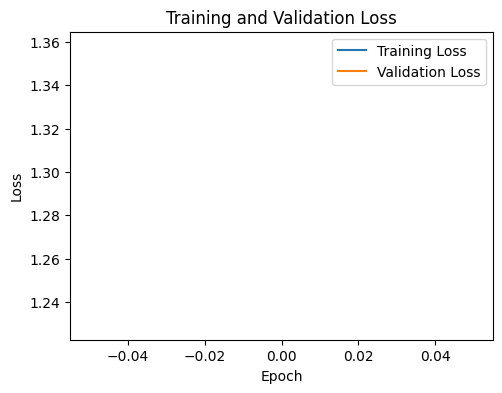

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [20]:

model.eval()
test_y_true = []
test_y_pred = []

with torch.no_grad():
    correct = 0
    total = 0
    for batch in load_test:
        images = batch[0].to(device)
        labels = batch[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        test_y_true.extend(labels.cpu().numpy())
        test_y_pred.extend(predicted.cpu().numpy())

        del images, labels, outputs


KeyboardInterrupt: 

Accuracy of the network on the 16 test images: 53.06334371754932 %


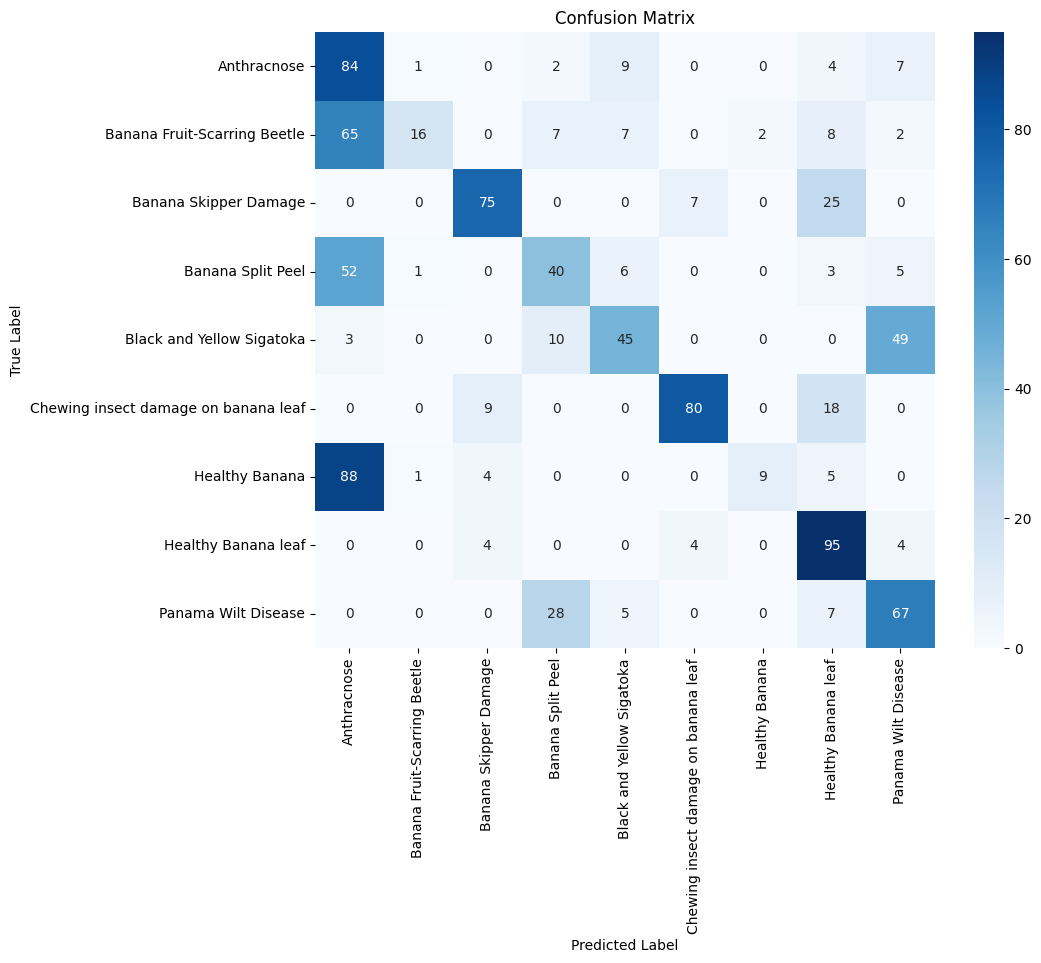

In [ ]:
print('Accuracy of the network on the {} test images: {} %'.format(len(load_test)*batch_size, 100 * correct / total))

cm = confusion_matrix(test_y_true, test_y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_map.values(), yticklabels=labels_map.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

real world data from build dataset
dataset manually collected and verified through google search which is then augmented.

In [22]:
model.eval()
build_y_true = []
build_y_pred = []

with torch.no_grad():
    correct = 0
    total = 0
    # change to buuild dataset
    for images, labels in load_build:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        build_y_true.extend(labels.cpu().numpy())
        build_y_pred.extend(predicted.cpu().numpy())
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(len(load_build)*batch_size, 100 * correct / total))

KeyboardInterrupt: 

Accuracy of the network on the 1024 build images: 12.5 %
[[ 0  0  0  1 21  4  0  0 14]
 [ 0  0  0  6 26  0  0  0  8]
 [ 0  0  0  1  8 14  0  3 14]
 [ 0  0  0  2 19  1  0  0 18]
 [ 0  0  0  3 20  0  0  2 15]
 [ 0  0  0  2 22  5  0  0 11]
 [ 0  1  0  3 35  0  0  0  1]
 [ 1  0  2  0 12 12  0  3 10]
 [ 0  0  0  2 22  1  0  0 15]]


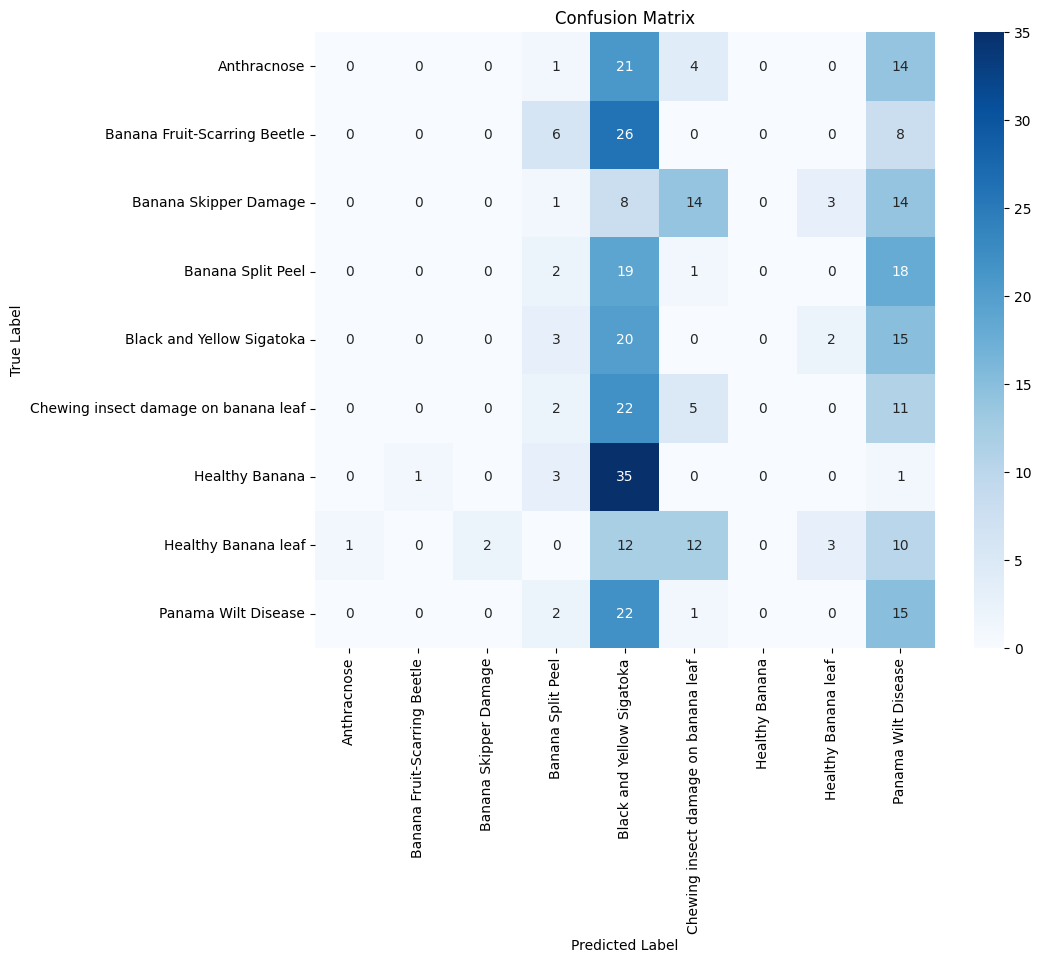

In [33]:
print('Accuracy of the network on the {} build images: {} %'.format(len(load_build)*batch_size, 100 * correct / total))
cm = confusion_matrix(build_y_true, build_y_pred)

print(cm)
# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_map.values(), yticklabels=labels_map.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [23]:
# prompt: save hyperparameters and results from the learning rate, epoch, batch size, losses and accuracies, test_y_pred and test_y_true, build_y_true and build_y_pred

import json
import os
import numpy as np # Import numpy

# Define the directory to save the results
results_dir = root_dir + "/bananadata/results/cnn"
os.makedirs(results_dir, exist_ok=True)

# Define hyperparameters and results
hyperparameters = {
    "learning_rate": learning_rate,
    "epoch": num_epochs,
    "batch_size": batch_size,
    "optimizer": "SGD",
    "loss_function": "CrossEntropyLoss",
    "model_architecture": "VGG16"
}

# Convert numpy arrays to lists for JSON serialization
results = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "val_accuracies": val_accuracies,
    "test_y_true": [int(x) for x in test_y_true], # Convert to int
    "test_y_pred": [int(x) for x in test_y_pred], # Convert to int
    "build_y_true": [int(x) for x in build_y_true], # Convert to int
    "build_y_pred": [int(x) for x in build_y_pred], # Convert to int
}

test_index = 2
# Save hyperparameters
hyperparameters_path = os.path.join(results_dir, f"hyperparameters{test_index}.json")
with open(hyperparameters_path, "w") as f:
    json.dump(hyperparameters, f, indent=4)
print(f"Hyperparameters saved to {hyperparameters_path}")

# Save results
results_path = os.path.join(results_dir, f"results{test_index}.json")
with open(results_path, "w") as f:
    json.dump(results, f)
print(f"Results saved to {results_path}")

Hyperparameters saved to /home/jovyan/bananadata/bananadata/results/cnn/hyperparameters2.json
Results saved to /home/jovyan/bananadata/bananadata/results/cnn/results2.json


In [24]:

# Save the model
save_dir = results_dir+"/models"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, f"CNNmodel{test_index}.pth")
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /home/jovyan/bananadata/bananadata/results/cnn/models/CNNmodel2.pth


In [25]:
# Save the transform
transform_path = os.path.join(save_dir, f"transform{test_index}.pth")
torch.save(transform, transform_path)
print(f"Transform saved to {transform_path}")

Transform saved to /home/jovyan/bananadata/bananadata/results/cnn/models/transform2.pth


In [26]:
# prompt: save the optimizer

# Save the optimizer state
optimizer_path = os.path.join(save_dir, f"optimizer{test_index}.pth")
torch.save(optimizer.state_dict(), optimizer_path)
print(f"Optimizer state saved to {optimizer_path}")

Optimizer state saved to /home/jovyan/bananadata/bananadata/results/cnn/models/optimizer2.pth
